2025-10-01 19:31:16.184283: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759318276.209686  139792 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759318276.215720  139792 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-01 19:31:16.239605: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-01 19:31:19.671210: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL

449/449 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


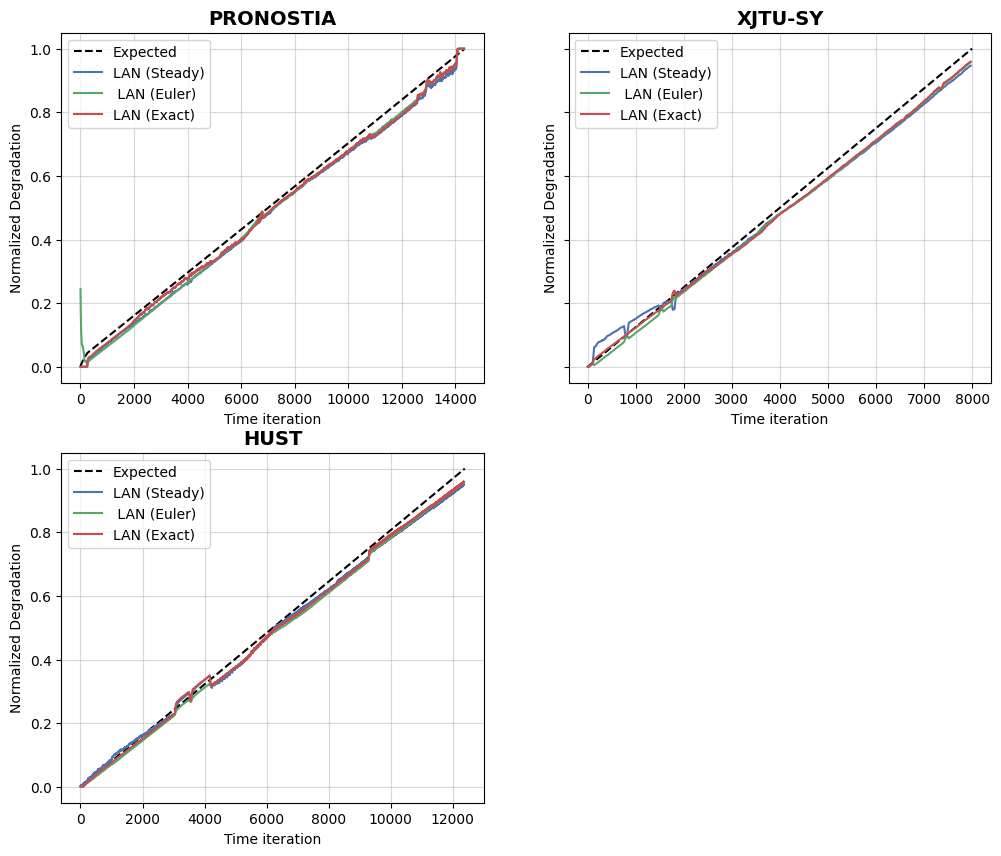

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras._tf_keras.keras.models import Model
from keras._tf_keras.keras.layers import Input, Dense, Reshape, Conv1D
from sklearn.preprocessing import StandardScaler
from utils.preprocess import process_features
from LAN import LAN

plot_dir = 'plots'

# Bearings dictionary
bearings = {
    "data/tf_features_pronostia": "Bearing1_1_features.csv",
    "data/tf_features_xjtu": "Bearing1_1_features_with_labels.csv",
    "data/tf_features_hust": "Bearing1_features.csv",
}

bearing_titles = {
    "data/tf_features_pronostia": "PRONOSTIA",
    "data/tf_features_xjtu": "XJTU-SY",
    "data/tf_features_hust": "HUST"
}

# Model info: name -> mode for LiquidAttention and legend label
models_info = {
    'RUL_LAN_Steady': ('steady', 'LAN (Steady)'),
    'RUL_LAN_Euler': ('euler', ' LAN (Euler)'),
    'RUL_LAN_Exact': ('exact', 'LAN (Exact)')
}

# Neural network
def build_model(input_shape=None, mode_list=['steady']):
    if isinstance(input_shape, int):
        input_shape = (input_shape,)
    inp = Input(shape=input_shape)
    x = Reshape((1, input_shape[0]))(inp)
    x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(x)
    x = Conv1D(16, kernel_size=2, activation='relu', padding='same')(x)
    for mode in mode_list:
        x = LAN(d_model=16, num_heads=8, mode=mode, return_sequences=False)(x)
    out = Dense(1, activation='linear')(x)
    return Model(inp, out)

# Moving average
def moving_average(data, window_size=30):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Directories
dir_path = os.getcwd()
weights_dir = os.path.join(dir_path, 'model_weights')
feature_base_dir = dir_path

# Prepare figure: 1 row, columns = number of bearings
columns = len(bearings)
# Prepare figure: 2 rows, 2 columns
plt.style.use('seaborn-v0_8-deep')
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)

# Flatten for easier indexing
axes = axes.flatten()

# Loop through bearings
for idx, (bearing_folder, bearing_file) in enumerate(bearings.items()):
    ax = axes[idx]
    df = pd.read_csv(os.path.join(feature_base_dir, bearing_folder, bearing_file))
    
    # Features
    xh = process_features(np.array(df['Horizontal'].apply(eval).tolist()))
    xv = process_features(np.array(df['Vertical'].apply(eval).tolist()))
    vibration_features = np.concatenate((xh, xv), axis=-1)
    t_data = np.array(df['Time'].values).reshape(-1,1)
    if "Temperature" in df.columns:
        T_data = (df['Temperature'].values + 273.15).reshape(-1, 1)
    else:
        T_data = np.full((len(df), 1), 25 + 273.15)
    X = np.concatenate([vibration_features, t_data, T_data], axis=1)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    if "Degradation" in df.columns:
        y_true = df['Degradation'].values
    else:
        y_true = np.linspace(0, 1, len(df))

    ax.plot(y_true, label='Expected', color='black', linestyle='--')

    # Loop through models
    for model_name, (mode_list, legend_label) in models_info.items():
        model = build_model(input_shape=X.shape[1], mode_list=[mode_list])
        model.load_weights(os.path.join(weights_dir, f'{model_name}.keras'))
        y_pred = model.predict(X).ravel()
        y_pred = np.clip(y_pred, 0, 1)
        ax.plot(moving_average(y_pred), label=legend_label)

    ax.set_title(bearing_titles[bearing_folder], fontweight='bold', fontsize=14)
    ax.set_xlabel('Time iteration')
    ax.set_ylabel('Normalized Degradation')
    ax.grid(alpha=0.5)
    ax.legend()

# Hide the empty 4th subplot (bottom-right)
fig.delaxes(axes[-1])

# plt.tight_layout()
# plt.savefig(f'{plot_dir}/liquid_attention_comparison.png', dpi=1200)
# plt.show()
